<a href="https://colab.research.google.com/github/jorgecif/CovidDisinformationDetection/blob/main/ModeloFinal_DetDesinfCOVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detección de desinformación relacionada con COVID19** - desarrollo del modelo


> Por: Jorge Orlando Cifuentes Cifuentes




Componentes principales:


*   Clasificador de la noticia
*   Extractor de palabras claves
*   Generador de alerta



### Librerías y funciones

In [17]:
# Generales
import warnings
warnings.filterwarnings('ignore')
#import csv
#import tensorflow as tf
import pandas as pd
import numpy as np
import os, joblib # Para exportar el modelo
from io import BytesIO
import requests
import time
from IPython.display import clear_output


# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns


# Machine learning
from keras.layers import concatenate

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Activation, Flatten, Bidirectional


from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

# Procesamiento lenguaje natural

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS, preprocess_string, strip_punctuation, strip_numeric
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(88)
import nltk
nltk.download('wordnet')




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [86]:
# Funciones para comparar modelos

def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc']) # Modifico "acc" por "accuracy"
    plt.plot(history.history['val_acc']) # Modifico "val_acc" por "val_accuracy"
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

def plot_compare_accs3(history1, history2, history3, name1="Red 1",
                      name2="Red 2", name3="Red 3", title="Graph title"):
    """Compara accuracies de tres entrenamientos con nombres name1, name2 y name3"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.plot(history3.history['acc'], color="red")
    plt.plot(history3.history['val_acc'], 'r--', color="red")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1,
                'Train ' + name2, 'Val ' + name2,  
                'Train ' + name3, 'Val ' + name3], 
               loc='lower right')
    plt.show()

def plot_compare_losses3(history1, history2, history3, name1="Red 1",
                        name2="Red 2", name3="Red 3", title="Graph title"):
    """Compara losses de tres entrenamientos con nombres name1, name2 y name3"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.plot(history3.history['loss'], color="red")
    plt.plot(history3.history['val_loss'], 'r--', color="red")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2,
                'Train ' + name3, 'Val ' + name3],
               loc='upper right')
    plt.show()

### Carga de datos

In [19]:
# Carga de datos
url_datos="https://github.com/jorgecif/CovidDisinformationDetection/blob/main/data/CovidHeadlinesDataset2.xlsx?raw=true"

datos = pd.read_excel(url_datos)

print("Se han cargado ", datos.shape[0], " titulares")



Se han cargado  15357  titulares


In [20]:
#Elimino duplicados de todas las columnas

datos2 = datos.drop_duplicates()
print(len(datos2))

# Elimino ambiguedades

datos3=datos2.drop_duplicates(['Text'], keep='first') # Elimino ambiguedades
print(len(datos3))

15315
13045


In [21]:
# Revuelvo los registros
datos3 = datos3.sample(frac = 1, random_state= 88) 
datos3=datos3.reset_index()
datos3=datos3.drop(["index"], axis=1)

# Muestra de los datos
datos3.head(5)


,Text,country,lang,label,URL,date,verificado_por
0,There is an herbal cure for COVID-19.,Sri Lanka,English,False,http://u.afp.com/asafoetidacoronavirus,2020-02-27 00:00:00,u.afp
1,This graphics shows that the number of death ...,France,French,False,https://factuel.afp.com/non-ce-visuel-ne-montr...,2020/05/08,AFP
2,Central Park hospital tents housed thousands o...,United States,English,False,https://www.rappler.com/newsbreak/fact-check/2...,2020-05-03 00:00:00,PolitiFact
3,Having 14 face masks is enough. You can reuse ...,Taiwan,Korean,False,https://tfc-taiwan.org.tw/articles/2599,2020-02-18 00:00:00,Taiwan FactCheck Center
4,CRAS (a social care center) is distributing 49...,Brazil,Portuguese,False,https://tamil.factcrescendo.com/factcheck-musl...,2020-05-04 00:00:00,Agência Lupa


In [22]:
# Descripción de los datos

datos3.describe(include="all")

,Text,country,lang,label,URL,date,verificado_por
count,13045,13045,13045,13045,12968,12894,13045
unique,13045,127,50,2,8225,315,129
top,Video of bodies being washed ashore being sha...,India,English,False,http://www.ecuadorchequea.com/las-mentiras-sob...,2020-04-03 00:00:00,AFP
freq,1,2380,6817,11921,14,680,971


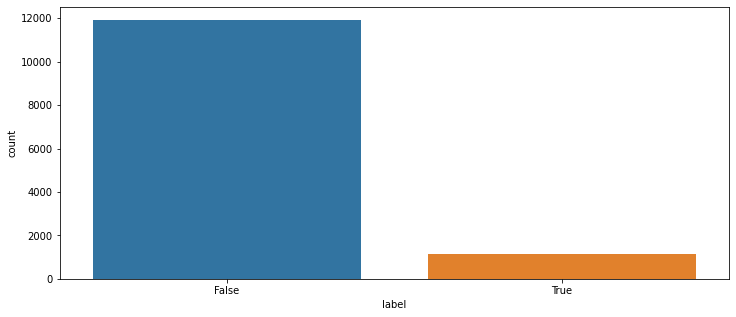

In [23]:
# Distribución de las categorías datos
plt.figure(figsize=(12,5))
sns.countplot("label", data=datos3)
plt.show()

In [24]:
# Filtro datos sólo en inglés
datos_ingles=datos3[datos3['lang']=="English"]
len(datos_ingles)

6817

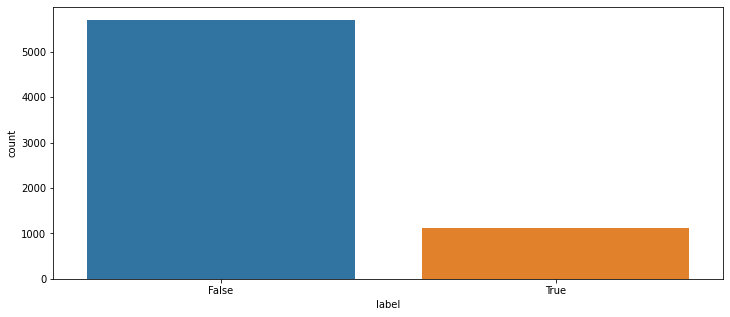

In [25]:
# Distribución de las categorías datos de trabajo filtrados en idioma inglés
plt.figure(figsize=(12,5))
sns.countplot("label", data=datos_ingles)
plt.show()

### Creación de conjuntos de datos

In [26]:
# Reservo unos datos para pruebas finales (datos que no se tocan)
datos_trabajo,datos_reserva = train_test_split(datos_ingles, test_size=0.1, random_state=88 )
datos_trabajo=datos_trabajo.reset_index()

datos_reserva=datos_reserva.reset_index()

print("Datos para trabajar: ", len(datos_trabajo))
print("Datos reservados para pruebas finales ", len(datos_reserva))

Datos para trabajar:  6135
Datos reservados para pruebas finales  682


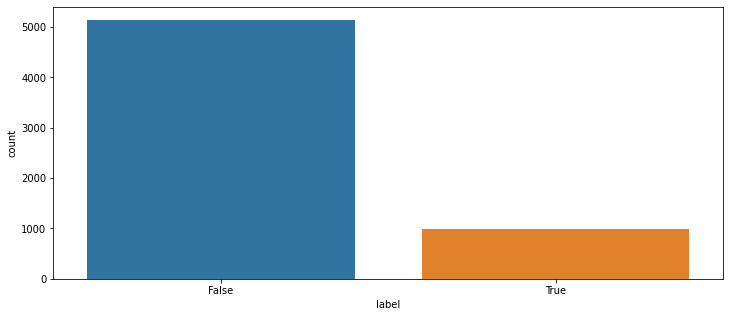

In [27]:
# Distribución de las categorías datos de trabajo
plt.figure(figsize=(12,5))
sns.countplot("label", data=datos_trabajo)
plt.show()

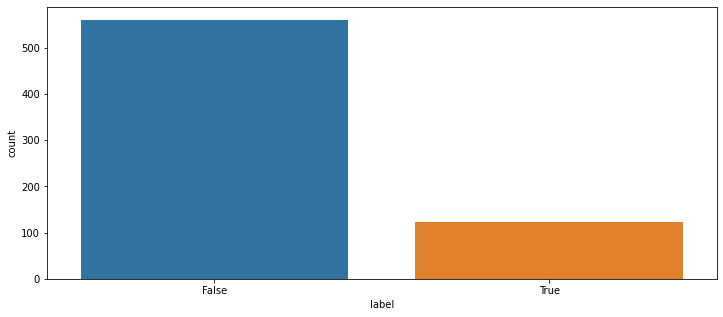

In [28]:
# Distribución de las categorías datos reservados
plt.figure(figsize=(12,5))
sns.countplot("label", data=datos_reserva)
plt.show()

### Carga de modelos 

In [29]:
# Cargo modelos desde archivos en repositorio github

mLink = 'https://github.com/jorgecif/CovidMisinformationDetection/blob/main/Modelos_clasificacion/vectorizer.pkl?raw=true'
mfile = BytesIO(requests.get(mLink).content)
vectorizer = joblib.load(mfile)

mLink = 'https://github.com/jorgecif/CovidMisinformationDetection/blob/main/Modelos_clasificacion/RF_model.pkl?raw=true'
mfile = BytesIO(requests.get(mLink).content)
rf_mod = joblib.load(mfile)

mLink = 'https://github.com/jorgecif/CovidMisinformationDetection/blob/main/Modelos_clasificacion/LOG_model.pkl?raw=true'
mfile = BytesIO(requests.get(mLink).content)
log_mod = joblib.load(mfile)



In [30]:
# Muestro modelo cargado
print(vectorizer)
print(log_mod)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


### Aplico modelo para clasficar la temática (Logistic Regression)

In [31]:
# Función para aplicar modelo
def aplicar_modelo(datos_revisar, tokenizador, modelo):
  tokenizador=tokenizador
  modelo=modelo
  datos_revisar=datos_revisar
  len_datos_revisar=len(datos_revisar)
  list_result=[]
  for i in range(0,len_datos_revisar):
    clear_output(wait=True)
    linea_revisar=datos_revisar["Text"][i]
    linea_revisar_token=tokenizador.transform([linea_revisar])
    resultado=modelo.predict(linea_revisar_token)
    list_result.append(resultado[0])
    print("Progreso ", np.round(i/len_datos_revisar*100,2),"%")
  return list_result


In [32]:
# Calculo predicciones de modelos con función
start = time.clock()                     
pred_model_clasifica=aplicar_modelo(datos_trabajo, vectorizer, log_mod)
end = time.clock()
print("Tiempo de entrenamiento: ", (end-start)/60, " minutos")

Progreso  99.98 %
Tiempo de entrenamiento:  0.3857306833333333  minutos


In [33]:
# Creo dataframe con columna adicional de predicción
datos_trabajo_pred=datos_trabajo
datos_trabajo_pred["pred_clasifica"]=pred_model_clasifica

### Aplico modelo para extraer la subtemática (LDA)

In [34]:
# Creo lista con documentos a procesar
headlines=datos_trabajo["Text"]
docs_train=headlines.values.tolist()

headlines=datos_reserva["Text"]
docs_test=headlines.values.tolist()

In [35]:
# Convertir palabras plural en singular
stemmer = SnowballStemmer("english")
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]

pd.DataFrame(data={'original word':original_words, 'stemmed':singles })

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [36]:
# Preprocesamiento

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

#### Bolsa de palabras

In [37]:
# Preprocesamiento

processed_docs = []

for doc in docs_train:
    processed_docs.append(preprocess(doc))

In [38]:
# Creo diccionario con GenSim
dictionary = gensim.corpora.Dictionary(processed_docs)


In [39]:
# Remover palabras poco comunes

dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [40]:
# Creo diccionario

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break


0 australian
1 compani
2 hank
3 hospit
4 quarantin
5 roll
6 staff
7 decemb
8 declar
9 outbreak
10 countri


In [41]:
# Remover palabras poco comunes

dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [42]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]


In [43]:
document_num = 4
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 23 ("econom") appears 1 time.
Word 24 ("view") appears 1 time.


#### Modelo LDA bolsa de palabras

In [44]:
# Creación del modelo
num_topics=5
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = num_topics, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2,
                                   alpha=[0.01]*num_topics,
                                   eta=[0.01]*len(dictionary.keys()))

In [45]:
# Muestro los temas creados

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.017*"test" + 0.013*"health" + 0.011*"australia" + 0.009*"travel" + 0.009*"clinic" + 0.008*"flight" + 0.008*"govern" + 0.008*"window" + 0.008*"hospit" + 0.008*"set"


Topic: 1 
Words: 0.022*"facebook" + 0.021*"post" + 0.021*"toilet" + 0.020*"paper" + 0.018*"show" + 0.017*"share" + 0.014*"novel" + 0.011*"lockdown" + 0.010*"thousand" + 0.010*"photo"


Topic: 2 
Words: 0.014*"infect" + 0.010*"pictur" + 0.009*"health" + 0.008*"spread" + 0.007*"case" + 0.007*"diseas" + 0.007*"mask" + 0.007*"countri" + 0.006*"report" + 0.006*"hand"


Topic: 3 
Words: 0.026*"case" + 0.016*"outbreak" + 0.012*"confirm" + 0.012*"state" + 0.012*"death" + 0.011*"trump" + 0.010*"health" + 0.010*"citi" + 0.009*"chines" + 0.008*"infect"


Topic: 4 
Words: 0.025*"health" + 0.018*"australia" + 0.014*"case" + 0.013*"test" + 0.013*"hospit" + 0.011*"public" + 0.009*"travel" + 0.008*"offic" + 0.007*"chief" + 0.007*"patient"




In [46]:
# Recuento de palabras de topics
num_words=10

lda_topics = lda_model.show_topics(num_words=num_words)
topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

for topic in lda_topics:
    topics.append(preprocess_string(topic[1], filters))
topics

[['test',
  'health',
  'australia',
  'travel',
  'clinic',
  'flight',
  'govern',
  'window',
  'hospit',
  'set'],
 ['facebook',
  'post',
  'toilet',
  'paper',
  'show',
  'share',
  'novel',
  'lockdown',
  'thousand',
  'photo'],
 ['infect',
  'pictur',
  'health',
  'spread',
  'case',
  'diseas',
  'mask',
  'countri',
  'report',
  'hand'],
 ['case',
  'outbreak',
  'confirm',
  'state',
  'death',
  'trump',
  'health',
  'citi',
  'chines',
  'infect'],
 ['health',
  'australia',
  'case',
  'test',
  'hospit',
  'public',
  'travel',
  'offic',
  'chief',
  'patient']]

#### Prueba

In [47]:
num = 78
unseen_document = docs_test[num]
print(unseen_document)

 Video of a fire accident that took place at the Solapur Airport on 05 April 2020.


In [48]:
# Preprocesamiento
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
# Aplico modelo
prediction_lda=lda_model[bow_vector]

probs=[]
for i in range(0, len(prediction_lda)):
  probs.append(prediction_lda[i][1])
max_probs=max(probs)


for i in range(0,len(prediction_lda)):
  if max_probs==prediction_lda[i][1]:
    position=i
    break
position


0

In [49]:
topics[position]

['test',
 'health',
 'australia',
 'travel',
 'clinic',
 'flight',
 'govern',
 'window',
 'hospit',
 'set']

In [50]:
# Creo función para extraer subtemáticas

def topics_lda(documento):
  unseen_document=documento
  # Preprocesamiento
  bow_vector = dictionary.doc2bow(preprocess(unseen_document))
  # Aplico modelo
  prediction_lda=lda_model[bow_vector]

  probs=[]
  for i in range(0, len(prediction_lda)):
    probs.append(prediction_lda[i][1])
  max_probs=max(probs)


  for i in range(0,len(prediction_lda)):
    if max_probs==prediction_lda[i][1]:
      position=i
      break
  return position


In [51]:
# Pruebo función predicción
num = 78
unseen_document = docs_test[num]
pred=topics_lda(unseen_document)
pred

0

In [52]:
# Aplico modelo LDA a conjunto de datos del dataframe

datos_revisar=datos_trabajo["Text"]
len_datos_revisar=len(datos_revisar)

start = time.clock()

list_result_id=[]
list_result_words=[]

for i in range(0,len_datos_revisar):
  clear_output(wait=True)
  id_predict=topics_lda(datos_revisar[i])
  list_result_id.append(id_predict)
  list_result_words.append(str(topics[id_predict]))
  print("Progreso ", np.round(i/len_datos_revisar*100,2),"%")

end = time.clock()
print("Tiempo de entrenamiento: ", (end-start)/60, " minutos")


Progreso  99.98 %
Tiempo de entrenamiento:  0.4527867833333333  minutos


In [53]:
# Creo dataframe con columna adicional de predicción y palabras

datos_trabajo_pred["pred_topics_id"]=list_result_id
datos_trabajo_pred["pred_topics_words"]=list_result_words

In [54]:
# Reviso el dataframe
datos_trabajo_pred.head()

,index,Text,country,lang,label,URL,date,verificado_por,pred_clasifica,pred_topics_id,pred_topics_words
0,12405,Australian hospital staff rolled in a Wilson ...,United States,English,False,https://hoax-alert.leadstories.com/3471894-fac...,2020/03/12,LeadStories,5,0,"['test', 'health', 'australia', 'travel', 'cli..."
1,7226,WHO declared COVID-19 to be the abbreviation f...,India,English,False,https://english.factcrescendo.com/2020/02/14/w...,2020-02-14 00:00:00,FactCrescendo,0,0,"['test', 'health', 'australia', 'travel', 'cli..."
2,10724,Claims of cures for COVID-19 from multiple cou...,Sri Lanka,English,False,https://srilanka.factcrescendo.com/english/fac...,2020-02-03 00:00:00,srilanka.factcrescendo,0,0,"['test', 'health', 'australia', 'travel', 'cli..."
3,723,The government was supposedly not buying evid...,Spain,English,False,https://maldita.es/malditobulo/2020/03/29/gobi...,2020-03-24 00:00:00,maldita.es,2,2,"['infect', 'pictur', 'health', 'spread', 'case..."
4,2909,Industrialist Ratan Tata’s view on economic do...,India,English,False,https://english.factcrescendo.com/2020/04/11/f...,2020-04-11 00:00:00,FactCrescendo,0,0,"['test', 'health', 'australia', 'travel', 'cli..."


In [55]:
# Concateno columnas de texto
datos_analizar=datos_trabajo_pred

datos_analizar["text_topics"]=datos_analizar["pred_topics_words"]+datos_analizar["Text"]

# Concateno columnas numéricas de metadatos

meta_list=[]
for i in range(0, len(datos_analizar)):
  lista=np.asarray(datos_analizar["pred_clasifica"][i]).astype(np.int32),np.asarray(datos_analizar["pred_topics_id"][i]).astype(np.int32)
  lista=np.asarray(lista).astype(np.int32)

  meta_list.append(lista)

# Creo en dataframe columna adicional
datos_analizar["metadatos"]=meta_list



In [183]:
datos_analizar.tail(20)

,index,Text,country,lang,label,URL,date,verificado_por,pred_clasifica,pred_topics_id,pred_topics_words,text_topics,metadatos
6115,1908,Photo shows dozens of wooden coffins of people...,Kenya,English,False,https://africacheck.org/fbcheck/photo-of-migra...,2020-03-23 00:00:00,AfricaCheck,0,0,"['test', 'health', 'australia', 'travel', 'cli...","['test', 'health', 'australia', 'travel', 'cli...","[0, 0]"
6116,9380,Chief Secretary of West Bengal was not follow...,India,English,False,https://www.boomlive.in/fake-news/2013-photo-o...,2020/05/08,BOOM FactCheck,6,1,"['facebook', 'post', 'toilet', 'paper', 'show'...","['facebook', 'post', 'toilet', 'paper', 'show'...","[6, 1]"
6117,786,"3,500 Italians potentially infected with the n...",Brazil,English,False,https://aosfatos.org/noticias/e-falso-que-3500...,2020-02-29 00:00:00,Aos Fatos,0,1,"['facebook', 'post', 'toilet', 'paper', 'show'...","['facebook', 'post', 'toilet', 'paper', 'show'...","[0, 1]"
6118,18,The death toll from China’s coronavirus outbre...,China,English,True,https://www.adelaidenow.com.au/lifestyle/healt...,2020-05-03 00:00:00,adelaidenow.au,0,0,"['test', 'health', 'australia', 'travel', 'cli...","['test', 'health', 'australia', 'travel', 'cli...","[0, 0]"
6119,6474,Video posts viewed thousands of times purport ...,South Africa,English,False,https://factcheck.afp.com/video-was-edited-mak...,2020-04-04 00:00:00,AFP,2,0,"['test', 'health', 'australia', 'travel', 'cli...","['test', 'health', 'australia', 'travel', 'cli...","[2, 0]"
6120,10905,"China seeks court’s approval to kill 20,000 c...",India,English,False,https://www.vishvasnews.com/english/health/fac...,2020/02/12,Vishvas News,0,0,"['test', 'health', 'australia', 'travel', 'cli...","['test', 'health', 'australia', 'travel', 'cli...","[0, 0]"
6121,7941,Coronavirus quarantine could spark an online l...,China,English,True,https://www.afghanistannews.net/news/264116162...,2020-12-03 00:00:00,afghanistannews.net,0,0,"['test', 'health', 'australia', 'travel', 'cli...","['test', 'health', 'australia', 'travel', 'cli...","[0, 0]"
6122,6451,"UK coronavirus cases double to eight, governme...",United Kingdom,English,True,http://www.aaj.tv/english/latest/uk-coronaviru...,2020-02-12 00:00:00,aaj.tv,0,1,"['facebook', 'post', 'toilet', 'paper', 'show'...","['facebook', 'post', 'toilet', 'paper', 'show'...","[0, 1]"
6123,6746,A video showing law enforcement officers beati...,Nigeria,English,False,https://factcheck.afp.com/old-video-showing-po...,2020-04-13 00:00:00,factcheck.afp,0,0,"['test', 'health', 'australia', 'travel', 'cli...","['test', 'health', 'australia', 'travel', 'cli...","[0, 0]"
6124,8839,Kerala vlogger discharged after he was tested ...,India,English,True,https://www.afghanistannews.net/news/264259797...,2020-02-25 00:00:00,afghanistannews.net,5,0,"['test', 'health', 'australia', 'travel', 'cli...","['test', 'health', 'australia', 'travel', 'cli...","[5, 0]"


In [57]:
datos_analizar["metadatos"][0]

array([5, 0], dtype=int32)

In [58]:
datos_analizar["text_topics"][0]

"['test', 'health', 'australia', 'travel', 'clinic', 'flight', 'govern', 'window', 'hospit', 'set'] Australian hospital staff rolled in a Wilson volleyball to keep Tom Hanks company in quarantine."

In [59]:
datos_analizar["metadatos"][0]

array([5, 0], dtype=int32)

### Aplico modelo unificado LSTM

#### Preparación de los datos

In [60]:
# Convierto categorías en números - datos de trabajo

category_dict = {value:index for index, value in enumerate(datos_trabajo_pred["label"].unique())} # Extraigo categorías de todos los datos

# Extraigo datos de dataframe
corpus_trabajo = datos_analizar["text_topics"] # Columna de text NLP - Input 1
meta = datos_analizar["metadatos"] # Columna de metadatos numerica - Input 2
results_trabajo = datos_analizar["label"].map(category_dict) # Prediccion (0 falso, 1 verdadero)
meta=meta.values.tolist()
meta_arr = np.array(meta)

In [61]:
# Parámetros
n_most_common_words = 10000
max_len = 300

# Creo tokenizador con todos los datos
corpus = datos_analizar["text_topics"]
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(corpus.values)
word_index = tokenizer.word_index
print('Se encontraron %s tokens únicos' % len(word_index))

Se encontraron 20961 tokens únicos


In [62]:
# Tokenización datos de trabajo
corpus_trabajo = datos_analizar["text_topics"]
sequences = tokenizer.texts_to_sequences(corpus_trabajo.values)
X = pad_sequences(sequences, maxlen=max_len)

#### Train - test split

In [63]:
# Datos NLP (Input 1)
x_train1,x_test1, y_train,y_test = train_test_split(X, results_trabajo, test_size=0.2, random_state=88 )

# Datos numéricos - metadatos (Input 2)
x_train2,x_test2, y_train2,y_test2 = train_test_split(meta_arr, results_trabajo, test_size=0.2, random_state=88 )


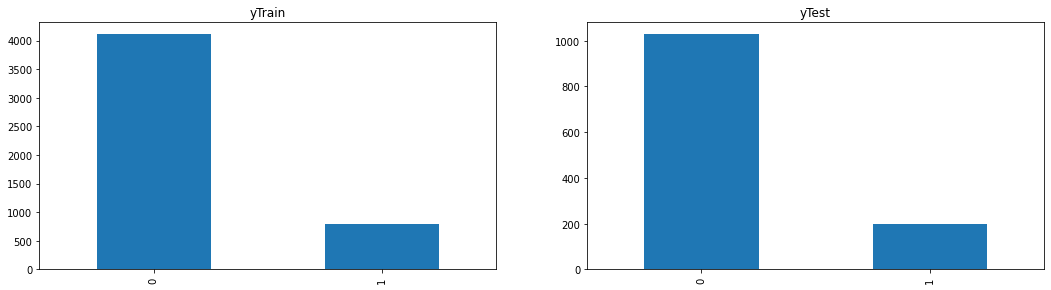

In [64]:
# Visualizo el balance de las clases luego de la división para verificar que no exista un desbalance
df_y_train = pd.DataFrame({'yTrain': y_train})

df_y_test = pd.DataFrame({'yTest': y_test})


fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 10))
plt.subplot(2, 2, 1).set_title('yTrain')
df_y_train["yTrain"].value_counts().plot(kind='bar')

plt.subplot(2, 2, 2).set_title('yTest')
df_y_test["yTest"].value_counts().plot(kind='bar')

#### Modelo base de una sóla entrada redes recurrentes - RNN con entrada train (Solo texto del titular de la noticia - sin información adicional del modelo LDA)

In [95]:
# Convierto categorías en números - datos de trabajo

category_dict_base = {value:index for index, value in enumerate(datos_trabajo_pred["label"].unique())} # Extraigo categorías de todos los datos

# Extraigo datos de dataframe
corpus_trabajo_base = datos_analizar["Text"] # Columna input única
results_trabajo_base = datos_analizar["label"].map(category_dict) # Prediccion

In [97]:
# Parámetros
n_most_common_words = 10000
max_len = 300

# Creo tokenizador con todos los datos
corpus_base = datos_analizar["Text"]
tokenizer_base = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer_base.fit_on_texts(corpus_base.values)
word_index_base = tokenizer_base.word_index
print('Se encontraron %s tokens únicos' % len(word_index_base))

Se encontraron 20921 tokens únicos


In [98]:
# Tokenización datos de trabajo
corpus_trabajo_base = datos_analizar["Text"]
sequences_base = tokenizer.texts_to_sequences(corpus_trabajo_base.values)
X_base = pad_sequences(sequences_base, maxlen=max_len)

In [99]:
# Datos Input única
x_train_base,x_test_base, y_train_base,y_test_base = train_test_split(X_base, results_trabajo_base, test_size=0.2, random_state=88 )


In [100]:
# Parámetros de la red
epochs = 20
emb_dim = 128
batch_size = 256

In [101]:
# Creación del modelo y compilación

model_base = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.1),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_base.summary()

# Compilación

model_base.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 128)          1280000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 300, 128)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [102]:
# Entrenamiento

start=time.clock()

history_base = model_base.fit(x_train_base, y_train_base, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
end = time.clock()

tiempo_base=(end-start)/60
print("Tiempo de entrenamiento: ", tiempo_base, " minutos")

Epoch 1/20
16/16 [==============================] - 10s 595ms/step - loss: 0.6036 - acc: 0.7937 - val_loss: 0.4360 - val_acc: 0.8371
Epoch 2/20
16/16 [==============================] - 9s 574ms/step - loss: 0.4239 - acc: 0.8556 - val_loss: 0.3522 - val_acc: 0.9043
Epoch 3/20
16/16 [==============================] - 9s 572ms/step - loss: 0.3402 - acc: 0.8963 - val_loss: 0.2792 - val_acc: 0.9043
Epoch 4/20
16/16 [==============================] - 9s 573ms/step - loss: 0.2432 - acc: 0.9052 - val_loss: 0.1994 - val_acc: 0.9216
Epoch 5/20
16/16 [==============================] - 9s 575ms/step - loss: 0.1631 - acc: 0.9483 - val_loss: 0.1621 - val_acc: 0.9420
Epoch 6/20
16/16 [==============================] - 9s 572ms/step - loss: 0.1059 - acc: 0.9692 - val_loss: 0.1383 - val_acc: 0.9501
Epoch 7/20
16/16 [==============================] - 9s 572ms/step - loss: 0.0860 - acc: 0.9748 - val_loss: 0.1445 - val_acc: 0.9430
Epoch 8/20
16/16 [==============================] - 9s 574ms/step - loss: 0

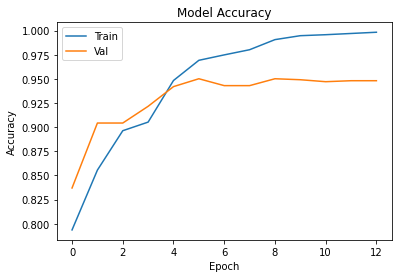

In [105]:
# Resultados

# Accuracy
plot_acc(history_base)

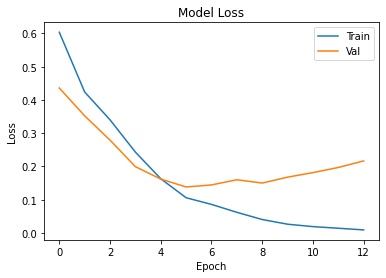

In [106]:
# Loss

plot_loss(history_base)

#### Modelo base de una sóla entrada redes recurrentes - RNN con entrada train1 (texto + palabras de LDA)

In [81]:
# Parámetros de la red
epochs = 20
emb_dim = 128
batch_size = 256

In [82]:
# Creación del modelo y compilación

model_RNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.1),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_RNN.summary()

# Compilación

model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 128)          1280000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 300, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [83]:
# Entrenamiento

start=time.clock()

history_RNN = model_RNN.fit(x_train1, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
end = time.clock()

tiempo_base=(end-start)/60
print("Tiempo de entrenamiento: ", tiempo_base, " minutos")

Epoch 1/20
16/16 [==============================] - 10s 615ms/step - loss: 0.5923 - acc: 0.8008 - val_loss: 0.4489 - val_acc: 0.8371
Epoch 2/20
16/16 [==============================] - 9s 575ms/step - loss: 0.3786 - acc: 0.8663 - val_loss: 0.3015 - val_acc: 0.9043
Epoch 3/20
16/16 [==============================] - 9s 575ms/step - loss: 0.2572 - acc: 0.9047 - val_loss: 0.2015 - val_acc: 0.9277
Epoch 4/20
16/16 [==============================] - 9s 573ms/step - loss: 0.1573 - acc: 0.9498 - val_loss: 0.1584 - val_acc: 0.9440
Epoch 5/20
16/16 [==============================] - 9s 572ms/step - loss: 0.1058 - acc: 0.9692 - val_loss: 0.1345 - val_acc: 0.9521
Epoch 6/20
16/16 [==============================] - 9s 571ms/step - loss: 0.0582 - acc: 0.9817 - val_loss: 0.1347 - val_acc: 0.9572
Epoch 7/20
16/16 [==============================] - 9s 572ms/step - loss: 0.0335 - acc: 0.9885 - val_loss: 0.1469 - val_acc: 0.9562
Epoch 8/20
16/16 [==============================] - 9s 571ms/step - loss: 0

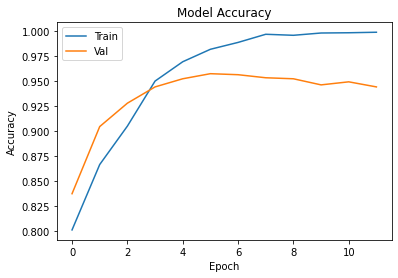

In [84]:
# Resultados

# Accuracy
plot_acc(history_RNN)

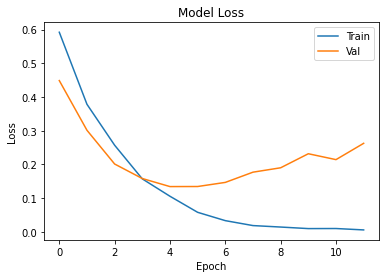

In [85]:
# Loss

plot_loss(history_RNN)

#### Modelo con multiples entradas

##### Modelo LSTM Sencilla

In [74]:
# Parámetros de la red
epochs = 30
emb_dim = 128
batch_size = 256
seq_length=X.shape[1]
embedding_size=n_most_common_words


In [75]:
# Creación de la red
nlp_input = Input(shape=(seq_length,), name='nlp_input')
meta_input = Input(shape=(2,), name='meta_input')
emb = Embedding(output_dim=emb_dim, input_dim=embedding_size, input_length=seq_length)(nlp_input)
nlp_out = (LSTM(64, dropout=0.7, recurrent_dropout=0.7, kernel_regularizer=regularizers.l2(0.01)))(emb)
x = concatenate([nlp_out, meta_input])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[nlp_input , meta_input], outputs=[x])

model.summary()

# Compilación

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 128)     1280000     nlp_input[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 64)           49408       embedding_1[0][0]                
__________________________________________________________________________________________________
meta_input (InputLayer)         [(None, 2)]          0                                            
_______________________________________________________________________________________

In [76]:
# Entrenamiento
start=time.clock()


historyFinal1=model.fit({'nlp_input': x_train1, 'meta_input': x_train2}, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])


end = time.clock()
tiempo_base=(end-start)/60
print("Tiempo de entrenamiento: ", tiempo_base, " minutos")

Epoch 1/30
16/16 [==============================] - 15s 941ms/step - loss: 2.0119 - acc: 0.7876 - val_loss: 1.6449 - val_acc: 0.8371
Epoch 2/30
16/16 [==============================] - 15s 920ms/step - loss: 1.3866 - acc: 0.8380 - val_loss: 1.1295 - val_acc: 0.8371
Epoch 3/30
16/16 [==============================] - 15s 919ms/step - loss: 0.9955 - acc: 0.8523 - val_loss: 0.8182 - val_acc: 0.9012
Epoch 4/30
16/16 [==============================] - 15s 920ms/step - loss: 0.6918 - acc: 0.8920 - val_loss: 0.5390 - val_acc: 0.9104
Epoch 5/30
16/16 [==============================] - 15s 919ms/step - loss: 0.4727 - acc: 0.9139 - val_loss: 0.3843 - val_acc: 0.9297
Epoch 6/30
16/16 [==============================] - 15s 920ms/step - loss: 0.3336 - acc: 0.9422 - val_loss: 0.2866 - val_acc: 0.9389
Epoch 7/30
16/16 [==============================] - 15s 925ms/step - loss: 0.2448 - acc: 0.9547 - val_loss: 0.2257 - val_acc: 0.9552
Epoch 8/30
16/16 [==============================] - 15s 941ms/step - 

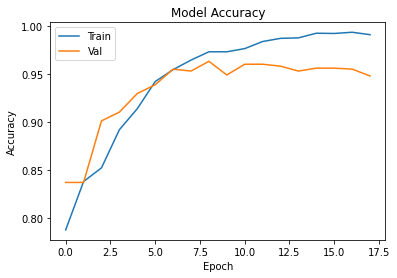

In [77]:
# Resultados

# Accuracy
plot_acc(historyFinal1)

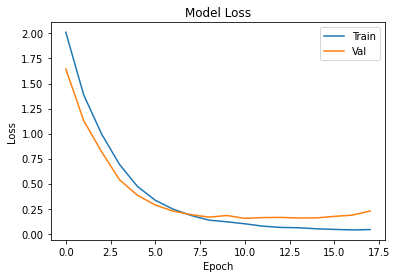

In [78]:
# Loss

plot_loss(historyFinal1)

##### Modelo LSTM Bidireccional

In [114]:
seq_length=X.shape[1]
embedding_size=n_most_common_words
classifier_neurons=32

In [115]:
# Creación de la red
nlp_input = Input(shape=(seq_length,), name='nlp_input')
meta_input = Input(shape=(2,), name='meta_input')
emb = Embedding(output_dim=emb_dim, input_dim=embedding_size, input_length=seq_length)(nlp_input)
nlp_out = Bidirectional(LSTM(64, dropout=0.7, recurrent_dropout=0.7, kernel_regularizer=regularizers.l2(0.01)))(emb)
x = concatenate([nlp_out, meta_input])
x = Flatten()(x)
x = Dense(classifier_neurons, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model_bLSTM = Model(inputs=[nlp_input , meta_input], outputs=[x])

model_bLSTM.summary()

# Compilación

model_bLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 300, 128)     1280000     nlp_input[0][0]                  
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 128)          98816       embedding_7[0][0]                
__________________________________________________________________________________________________
meta_input (InputLayer)         [(None, 2)]          0                                            
_______________________________________________________________________________________

In [116]:
# Entrenamiento
start=time.clock()

historyFinal2=model_bLSTM.fit({'nlp_input': x_train1, 'meta_input': x_train2}, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

end = time.clock()
tiempo_base=(end-start)/60
print("Tiempo de entrenamiento: ", tiempo_base, " minutos")

Epoch 1/20
16/16 [==============================] - 29s 2s/step - loss: 3.4362 - acc: 0.8332 - val_loss: 2.7544 - val_acc: 0.8371
Epoch 2/20
16/16 [==============================] - 28s 2s/step - loss: 2.3111 - acc: 0.8411 - val_loss: 1.8515 - val_acc: 0.8564
Epoch 3/20
16/16 [==============================] - 28s 2s/step - loss: 1.5791 - acc: 0.8780 - val_loss: 1.2924 - val_acc: 0.8371
Epoch 4/20
16/16 [==============================] - 28s 2s/step - loss: 1.0532 - acc: 0.8938 - val_loss: 0.8116 - val_acc: 0.9134
Epoch 5/20
16/16 [==============================] - 28s 2s/step - loss: 0.6865 - acc: 0.9269 - val_loss: 0.5445 - val_acc: 0.9338
Epoch 6/20
16/16 [==============================] - 28s 2s/step - loss: 0.4483 - acc: 0.9493 - val_loss: 0.3736 - val_acc: 0.9481
Epoch 7/20
16/16 [==============================] - 28s 2s/step - loss: 0.2956 - acc: 0.9626 - val_loss: 0.2741 - val_acc: 0.9542
Epoch 8/20
16/16 [==============================] - 28s 2s/step - loss: 0.2069 - acc: 0.96

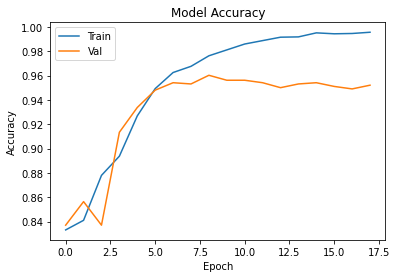

In [120]:
# Resultados

# Accuracy
plot_acc(historyFinal2)

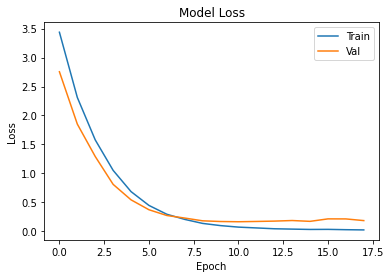

In [121]:
# Loss

plot_loss(historyFinal2)

### Comparación de resultados

#### RNN base sin LDA vs LSTM MultiInput

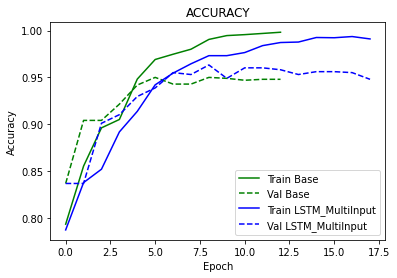

In [107]:
# Comparación - Accuracy (Base - LSTM multiple input)
plot_compare_accs(history_base, historyFinal1, 'Base', 'LSTM_MultiInput', 'ACCURACY')

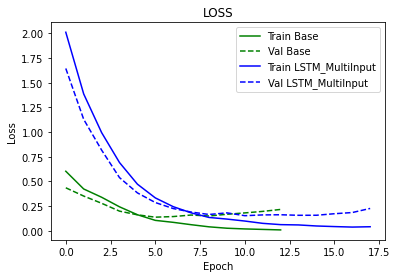

In [108]:
# Comparación - Loss (Base - LSTM multiple input)
plot_compare_losses(history_base, historyFinal1, 'Base', 'LSTM_MultiInput', 'LOSS')

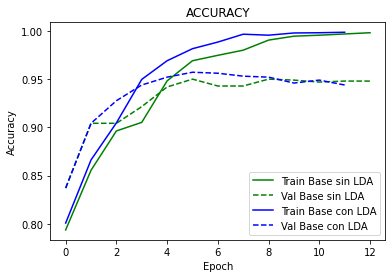

In [109]:
# Comparación - Accuracy (Base - LSTM multiple input)
plot_compare_accs(history_base, history_RNN, 'Base sin LDA', 'Base con LDA', 'ACCURACY')

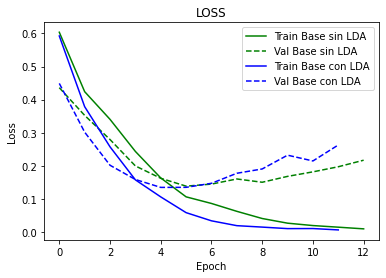

In [110]:
# Comparación - Loss (Base - LSTM multiple input)
plot_compare_losses(history_base, history_RNN, 'Base sin LDA', 'Base con LDA', 'LOSS')

#### RNN base vs LSTM MultiInput

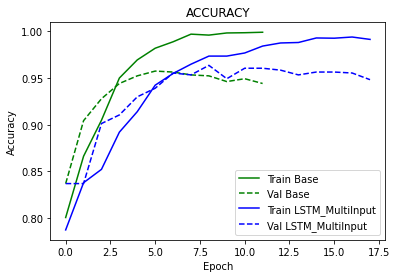

In [88]:
# Comparación - Accuracy (Base - LSTM multiple input)
plot_compare_accs(history_RNN, historyFinal1, 'Base', 'LSTM_MultiInput', 'ACCURACY')

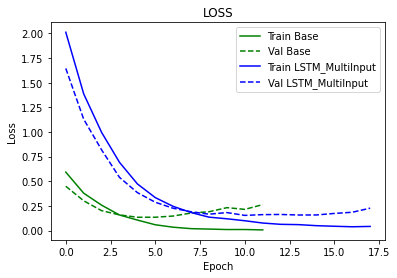

In [89]:
# Comparación - Loss (Base - LSTM multiple input)
plot_compare_losses(history_RNN, historyFinal1, 'Base', 'LSTM_MultiInput', 'LOSS')

#### LSTM MultiInput sencilla vs LSTM MultiInput bidireccional

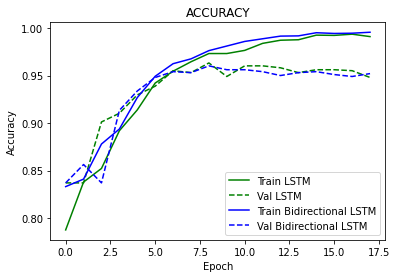

In [124]:
# Comparación - Accuracy (LSTM multiple input - Bidirectional LSTM multiple input)
plot_compare_accs(historyFinal1, historyFinal2, 'LSTM', 'Bidirectional LSTM', 'ACCURACY')

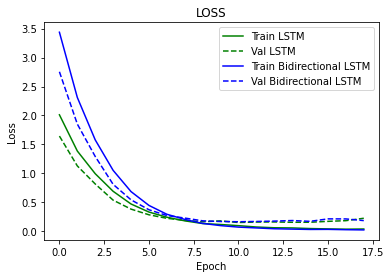

In [125]:
# Comparación - Loss (LSTM multiple input - Bidirectional LSTM multiple input)
plot_compare_losses(historyFinal1, historyFinal2, 'LSTM', 'Bidirectional LSTM', 'LOSS')

### Pruebas de predicción del modelo


*   Los datos reservados para pruebas se encuentran en el dataframe "datos_reserva"



In [202]:
# Prueba con textos de datos de reserva

text1=datos_reserva["Text"][11]
text2=datos_reserva["Text"][1]
text3=datos_reserva["Text"][55] 

print("Texto 1: ", text1)
print("Categoria real: ",datos_reserva["label"][11])

print("Texto 2: ", text2)
print("Categoria real: ",datos_reserva["label"][1])

print("Texto 3: ", text3)
print("Categoria real: ",datos_reserva["label"][55])

Texto 1:   MTN Uganda is giving out 122GB of data to customers for free in response to COVID-19.
Categoria real:  False
Texto 2:  Turmeric And Lemon Help Fight Against coronavirus.
Categoria real:  False
Texto 3:   What we need to do to defeat the coronavirus is to consume more alkaline foods above the virus’ pH level.
Categoria real:  False


In [203]:
# Función para prueba de predicciones

def news_alert(a, modelo_probar, tokenizer):
    clf=modelo_probar
    tok=tokenizer
    # Tokenizacion
    corpus_1=[]
    corpus_1.append(a)
    corpus_2=pd.Series(corpus_1)
    sequences_reserva = tok.texts_to_sequences(corpus_2.values)
    transform_vect_reserva= pad_sequences(sequences_reserva, maxlen=max_len)
    prediccion=clf.predict(transform_vect_reserva)
    prediccion_a = [np.array(prediccion)]
    if prediccion > 0.5:
      label= "NO"
    else:
      label = "SI"
    alerta=[prediccion,label]
    return alerta

In [217]:
n=22
text1=datos_reserva["Text"][n]
clasificar_texto=text1
resultado_prediccion=news_alert(clasificar_texto, model_base, tokenizer_base)

print("Texto", n,":", text1)
print("Categoria real: ",datos_reserva["label"][n])
print(" ")
print("Predicción: ")
print("Alerta de desinformación: ", resultado_prediccion[1]) 
print("Probabilidad asociada: ", resultado_prediccion[0][0])


Texto 22 : â€śBill Gates told us about the coronavirus in 2015.â€ť
Categoria real:  True
 
Predicción: 
Alerta de desinformación:  SI
Probabilidad asociada:  [0.0141885]


In [126]:
# Prueba Única

test=text2
  
corpus_t=[]
corpus_t.append(test)
corpus_t=pd.Series(corpus_t)
  
  
sequences_reserva = tokenizer.texts_to_sequences(corpus_t.values)
transform_vect_reserva= pad_sequences(sequences_reserva, maxlen=max_len)

transform_vect_reserva

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [127]:
prediccion222=model_base.predict(transform_vect_reserva)

In [128]:
len(prediccion222[0])

1

In [129]:
prediccion222

array([[0.00084391]], dtype=float32)

In [132]:
# Prueba con función

clasificar_texto=text3
print(clasificar_texto)

print("Modelo Base")
print(news_alert(clasificar_texto, model_base))



â€śBill Gates told us about the coronavirus in 2015.â€ť
Modelo Base
[[0.9812044]]
Alerta
None


In [186]:
n=234

text1=datos_trabajo["Text"][n]

print("Texto 1: ", text1)
print("Categoria real: ",datos_trabajo["label"][n])


clasificar_texto=text1
print(clasificar_texto)

print("Modelo Base")
print(news_alert(clasificar_texto, model_base))




Texto 1:   Coronavirus-infected chicken has been found in Bengaluru, India.
Categoria real:  False
 Coronavirus-infected chicken has been found in Bengaluru, India.
Modelo Base


TypeError: ignored

# Voy aquíiii

In [ ]:
X.shape

(6135, 300)

In [ ]:
# Creación del modelo y compilación

model_RNN2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1]), name='nlp_input'),
    tf.keras.layers.Input(shape=(1,), name='meta_input'),
    tf.keras.layers.Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.7),
    tf.keras.layers.LSTM(64, dropout=0.7, recurrent_dropout=0.7),
    tf.keras.layers.concatenate([nlp_out, meta_input]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_RNN2.summary()

# Compilación

model_RNN2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

TypeError: ignored

In [ ]:
emb_dim

In [ ]:
# Creación del modelo y compilación

nlp_input = Input(shape=(seq_length,), name='nlp_input')
meta_input = Input(shape=(10,), name='meta_input')



model_RNN2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.7),
    tf.keras.layers.LSTM(64, dropout=0.7, recurrent_dropout=0.7),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_RNN.summary()

# Compilación

model_RNN2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# entrenamiento

history_RNN2 = model_RNN2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

In [ ]:
# Resultados

# Accuracy
plot_acc(history_RNN2)

In [ ]:
# Loss

plot_loss(history_RNN2)